In [1]:
# Read in label file and return a dictionary {'filename' : label}.
def import_labels(label_file):
    labels = dict()

    import csv
    with open(label_file) as fd:
        csvreader = csv.DictReader(fd)

        for row in csvreader:
            labels[row['filename']] = int(row['label'])
    return labels

In [2]:
# Data Generator
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing import image
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

class DataGenerator(keras.utils.Sequence):

    def __init__(self, img_root_dir, labels_dict, batch_size, target_dim, preprocess_func=None, use_augmentation=False):
        self._labels_dict = labels_dict
        self._img_root_dir = img_root_dir
        self._batch_size = batch_size
        self._target_dim = target_dim
        self._preprocess_func = preprocess_func
        self._n_classes = len(set(self._labels_dict.values()))
        self._fnames_all = list(self._labels_dict.keys())
        self._use_augmentation = use_augmentation

        if self._use_augmentation:
            self._augmentor = ImageDataGenerator(
                rotation_range=40,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True,
                fill_mode='nearest'
            )
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self._fnames_all)) / self._batch_size)

    def on_epoch_end(self):
        self._indices = np.arange(len(self._fnames_all))
        np.random.shuffle(self._indices)

    def __getitem__(self, index):
        indices = self._indices[index * self._batch_size:(index+1)*self._batch_size]

        fnames = [self._fnames_all[k] for k in indices]
        X,Y = self.__load_files__(fnames)

        return X,Y

    def __load_files__(self, batch_filenames):
        X = np.empty((self._batch_size, *self._target_dim, 3))
        Y = np.empty((self._batch_size), dtype=int)

        for idx, fname in enumerate(batch_filenames):
            img_path = os.path.join(self._img_root_dir, fname)
            img = image.load_img(img_path, target_size=self._target_dim)
            x = image.img_to_array(img)
           
            if self._preprocess_func is not None:
                x = self._preprocess_func(x)

            X[idx,:] = x 
            Y[idx] = self._labels_dict[fname]-1

        if self._use_augmentation:
            it = self._augmentor.flow(X, batch_size=self._batch_size, shuffle=False)
            X = it.next()

        if self._preprocess_func is not None:
            X = self._preprocess_func(X/255.0)

        return X, tf.keras.utils.to_categorical(Y, num_classes=self._n_classes)

In [3]:
# Define properties for DataGenerator
batch_size = 1
input_shape = (200,200)

def preprocess(x):
    return x

In [4]:
# Evaluate the Model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate_model(model, datagen):
    LossAndAccuracy = model.evaluate(datagen, verbose=0)
    print('Loss: {0:7.5f} - Accuracy: {1:7.5f}'.format(LossAndAccuracy[0], LossAndAccuracy[1]))
    
def show_evaluate_model(model, datagen):
    #Confution Matrix
    y_pred = np.zeros(len(datagen))
    y_true = np.zeros(len(datagen))
    for idx in range(len(y_true)):
        y_true[idx] = np.argmax(datagen[idx][1], axis=1)
        Y_Predict = model.predict(datagen[idx][0], verbose=0)
        y_pred[idx] = np.argmax(Y_Predict, axis=1)

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    disp.plot(ax=ax, cmap=plt.cm.Blues)
    plt.xticks(rotation=90)
    plt.show()

Loss: 0.77933 - Accuracy: 0.86391


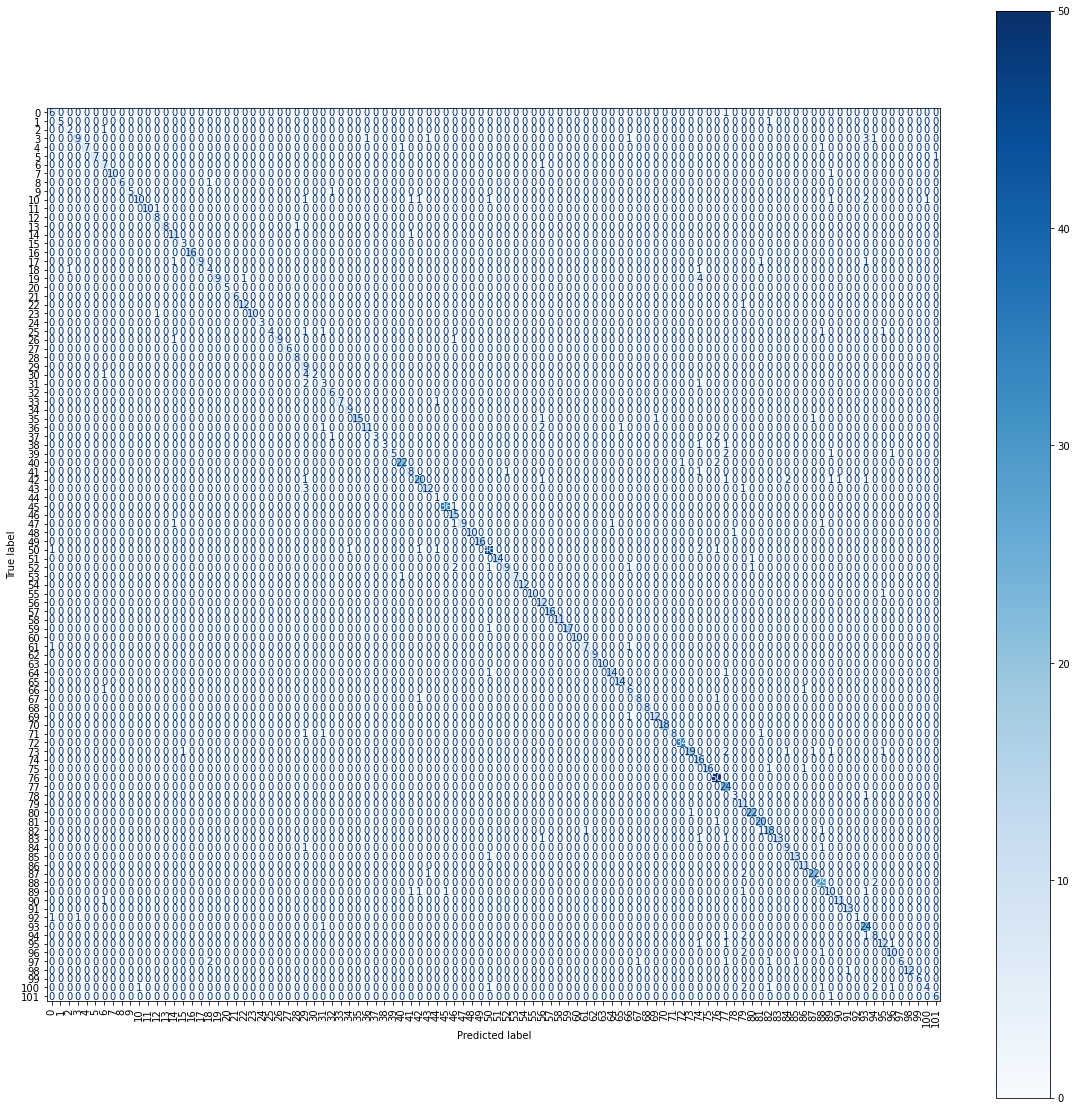

In [5]:
from keras.models import load_model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Input, Dropout, BatchNormalization, GlobalAveragePooling2D

# Load the Model
model = load_model('bestResultV02.h5')

# Get the Labels
y_validation = import_labels(r'labels\validation_labels.csv')
sorted(y_validation.items())

# Get validate Data
datagen_validation = DataGenerator('validation_data', y_validation, batch_size, input_shape, preprocess_func=preprocess)

evaluate_model(model, datagen_validation)
show_evaluate_model(model, datagen_validation)